![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [1]:
qb = QuantBook()
gbpusd = qb.AddForex("GBPUSD")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [3]:
import pickle

In [4]:
history = qb.History(gbpusd.Symbol, timedelta(hours=5200), Resolution.Hour)

In [5]:
type(history)

pandas.core.frame.DataFrame

In [6]:
history.head()

askclose  askhigh   asklow  askopen  bidclose  \
symbol    time                                                                 
GBPUSD 8G 2020-03-24 09:00:00   1.17540  1.17687  1.16856  1.17512   1.17513   
          2020-03-24 10:00:00   1.17529  1.17865  1.17366  1.17540   1.17474   
          2020-03-24 11:00:00   1.17066  1.17639  1.16978  1.17529   1.17022   
          2020-03-24 12:00:00   1.17844  1.17914  1.17037  1.17066   1.17807   
          2020-03-24 13:00:00   1.17636  1.18014  1.17215  1.17844   1.17607   

                               bidhigh   bidlow  bidopen     close      high  \
symbol    time                                                                 
GBPUSD 8G 2020-03-24 09:00:00  1.17651  1.16815  1.17467  1.175265  1.176690   
          2020-03-24 10:00:00  1.17834  1.17334  1.17513  1.175015  1.178495   
          2020-03-24 11:00:00  1.17603  1.16944  1.17474  1.170440  1.176210   
          2020-03-24 12:00:00  1.17886  1.17002  1.17022  1.178255  1.179000   
          2020-03-24 13:00:00  1.17985  1.17191  1.17807  1.176215  1.179995   

                                    low      open  
symbol    time                                     
GBPUSD 8G 2020-03-24 09:00:00  1.168355  1.174895  
          2020-03-24 10:00:00  1.173500  1.175265  
          2020-03-24 11:00:00  1.169610  1.175015  
          2020-03-24 12:00:00  1.170195  1.170440  
          2020-03-24 13:00:00  1.172030  1.178255

In [7]:
df = history.droplevel(level = 0) 

In [8]:
df.head()

,askclose,askhigh,asklow,askopen,bidclose,bidhigh,bidlow,bidopen,close,high,low,open
time,,,,,,,,,,,,
2020-03-24 09:00:00,1.17540,1.17687,1.16856,1.17512,1.17513,1.17651,1.16815,1.17467,1.175265,1.176690,1.168355,1.174895
2020-03-24 10:00:00,1.17529,1.17865,1.17366,1.17540,1.17474,1.17834,1.17334,1.17513,1.175015,1.178495,1.173500,1.175265
2020-03-24 11:00:00,1.17066,1.17639,1.16978,1.17529,1.17022,1.17603,1.16944,1.17474,1.170440,1.176210,1.169610,1.175015
2020-03-24 12:00:00,1.17844,1.17914,1.17037,1.17066,1.17807,1.17886,1.17002,1.17022,1.178255,1.179000,1.170195,1.170440
2020-03-24 13:00:00,1.17636,1.18014,1.17215,1.17844,1.17607,1.17985,1.17191,1.17807,1.176215,1.179995,1.172030,1.178255


In [9]:
df = df[['close', 'high', 'low', 'open']]

In [10]:
df.head()

,close,high,low,open
time,,,,
2020-03-24 09:00:00,1.175265,1.176690,1.168355,1.174895
2020-03-24 10:00:00,1.175015,1.178495,1.173500,1.175265
2020-03-24 11:00:00,1.170440,1.176210,1.169610,1.175015
2020-03-24 12:00:00,1.178255,1.179000,1.170195,1.170440
2020-03-24 13:00:00,1.176215,1.179995,1.172030,1.178255


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3712 entries, 2020-03-24 09:00:00 to 2020-10-27 00:00:00
Data columns (total 4 columns):
close    3712 non-null float64
high     3712 non-null float64
low      3712 non-null float64
open     3712 non-null float64
dtypes: float64(4)
memory usage: 145.0 KB


<AxesSubplot:xlabel='time'>

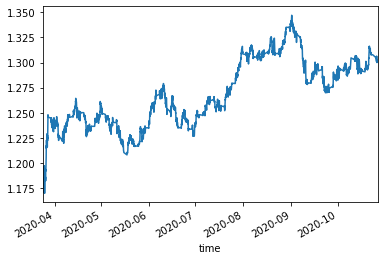

In [12]:
df['close'].plot()

In [13]:
# EMA - Exponential Moving Average indicators
# Commonly used periods are used to generage the EMA features - 8, 21, 50, 20

ema8 = ExponentialMovingAverage(8)
ema21 = ExponentialMovingAverage(21)
ema50 = ExponentialMovingAverage(50)
ema200 = ExponentialMovingAverage(200)

In [14]:
ema8.name = 'ema8'
ema21.name = 'ema21'
ema50.name = 'ema50'
ema200.name = 'ema200'

In [15]:
#example of setting range based on date
#momdf = qb.Indicator(mom, "SPY", datetime(2018,2,1), datetime(2018,4,1), Resolution.Daily)

In [16]:
ema8df = qb.Indicator(ema8, "GBPUSD",  timedelta(hours=5200), Resolution.Hour)
ema21df = qb.Indicator(ema21, "GBPUSD",  timedelta(hours=5200), Resolution.Hour)
ema50df = qb.Indicator(ema50, "GBPUSD",  timedelta(hours=5200), Resolution.Hour)
ema200df = qb.Indicator(ema200, "GBPUSD",  timedelta(hours=5200), Resolution.Hour)

In [17]:
ema8df.columns=['ema8']
ema21df.columns=['ema21']
ema50df.columns=['ema50']
ema200df.columns=['ema200']

In [18]:
# Stochastic Oscillator Indicator with 
stoc = Stochastic(14,1, 5)
stocdf = qb.Indicator(stoc, "GBPUSD",  timedelta(hours=5200), Resolution.Hour)
stocdf.tail()

,faststoch,stochastic,stochd,stochk
2020-10-26 20:00:00,25.965131,25.965131,30.831444,25.965131
2020-10-26 21:00:00,28.898129,28.898129,30.228609,28.898129
2020-10-26 22:00:00,33.710590,33.710590,29.333699,33.710590
2020-10-26 23:00:00,50.180505,50.180505,33.105790,50.180505
2020-10-27 00:00:00,57.438017,57.438017,39.238474,57.438017


In [ ]:
bb = BollingerBands(10, 2, MovingAverageType.Exponential)
bbdf = qb.Indicator(bb, "GBPUSD", timedelta(hours=5200), Resolution.Hour)
bbdf2 = bbdf.drop(['standarddeviation', 'bandwidth', 'percentb', 'bollingerbands', 'price'], 1)
bbdf2.head()


In [ ]:
combined_df = pd.concat([ema8df, ema21df, ema50df, ema200df, stocdf, bbdf2, df], axis=1)

In [ ]:
combined_df.tail()

In [ ]:

# import plotly.graph_objects as go
# def plot_pair(pair, name):
#     import plotly.graph_objects as go
#     fig = go.Figure(data=[go.Candlestick(x=pair.index,
#                     open=pair['open'],
#                     high=pair['high'],
#                     low=pair['low'],
#                     close=pair['close'])],
#                     layout=go.Layout(
#                         title=go.layout.Title(text=name),
#                         xaxis_title='Date',
#                         yaxis_title='Price',
#                         xaxis_rangeslider_visible=False
#         ))
    

#     #fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])
#     fig.show()


In [ ]:
# plot_pair(combined_df, 'GBPUSD')

In [ ]:
combined_df[combined_df.index.dayofweek < 5]

In [ ]:
combined_df.dropna(inplace=True)

In [ ]:
combined_df

# Saving dataframe to QC objectstore

In [ ]:
# save dataframe by serializing using pickle into json format and than using Quantconnect Object store
# for later retrival in the other notebooks.
serialized=pickle.dumps(combined_df)
qb.ObjectStore.SaveBytes("MyObject", serialized)
#after save check
deserialized=bytes(qb.ObjectStore.ReadBytes("MyObject"))
stored_df=pickle.loads(deserialized)

In [19]:
deserialized=bytes(qb.ObjectStore.ReadBytes("MyObject"))
stored_df=pickle.loads(deserialized)

In [20]:
stored_df.head()

,ema8,ema21,ema50,ema200,faststoch,stochastic,stochd,stochk,lowerband,middleband,upperband,close,high,low,open
2020-03-31 16:00:00,1.241157,1.238793,1.234806,1.205531,78.200692,78.200692,74.543519,78.200692,1.234438,1.240559,1.246681,1.243240,1.244075,1.240830,1.244050
2020-03-31 17:00:00,1.241247,1.239045,1.235071,1.205890,69.257386,69.257386,70.827788,69.257386,1.235368,1.240741,1.246115,1.241560,1.243240,1.240320,1.243240
2020-03-31 18:00:00,1.241621,1.239398,1.235379,1.206258,72.775031,72.775031,73.458387,72.775031,1.237383,1.241139,1.244896,1.242930,1.245180,1.241560,1.241560
2020-03-31 19:00:00,1.241177,1.239419,1.235545,1.206590,52.348578,52.348578,71.018866,52.348578,1.237280,1.240864,1.244448,1.239625,1.242930,1.239620,1.242930
2020-03-31 20:00:00,1.241053,1.239528,1.235744,1.206929,53.303199,53.303199,65.176977,53.303199,1.237224,1.240820,1.244416,1.240620,1.241860,1.239595,1.239625


In [21]:
combined_df = stored_df.copy()

In [22]:
mpf_df = stored_df[['close', 'high', 'low', 'open']]
mpf_df.columns = ['Close', 'High', 'Low', 'Open']
mpf_df['Volumes'] = 0

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
mpf_df.head()

,Close,High,Low,Open,Volumes
2020-03-31 16:00:00,1.243240,1.244075,1.240830,1.244050,0
2020-03-31 17:00:00,1.241560,1.243240,1.240320,1.243240,0
2020-03-31 18:00:00,1.242930,1.245180,1.241560,1.241560,0
2020-03-31 19:00:00,1.239625,1.242930,1.239620,1.242930,0
2020-03-31 20:00:00,1.240620,1.241860,1.239595,1.239625,0


# Displaying open, high, low, close data as candlesticks

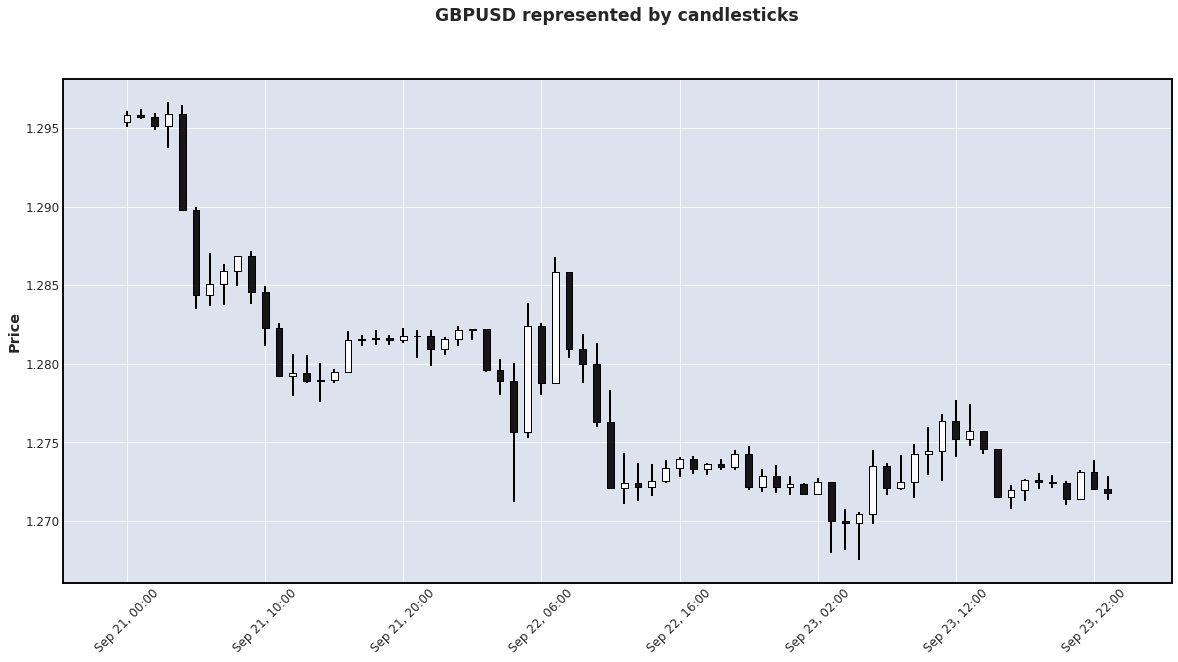

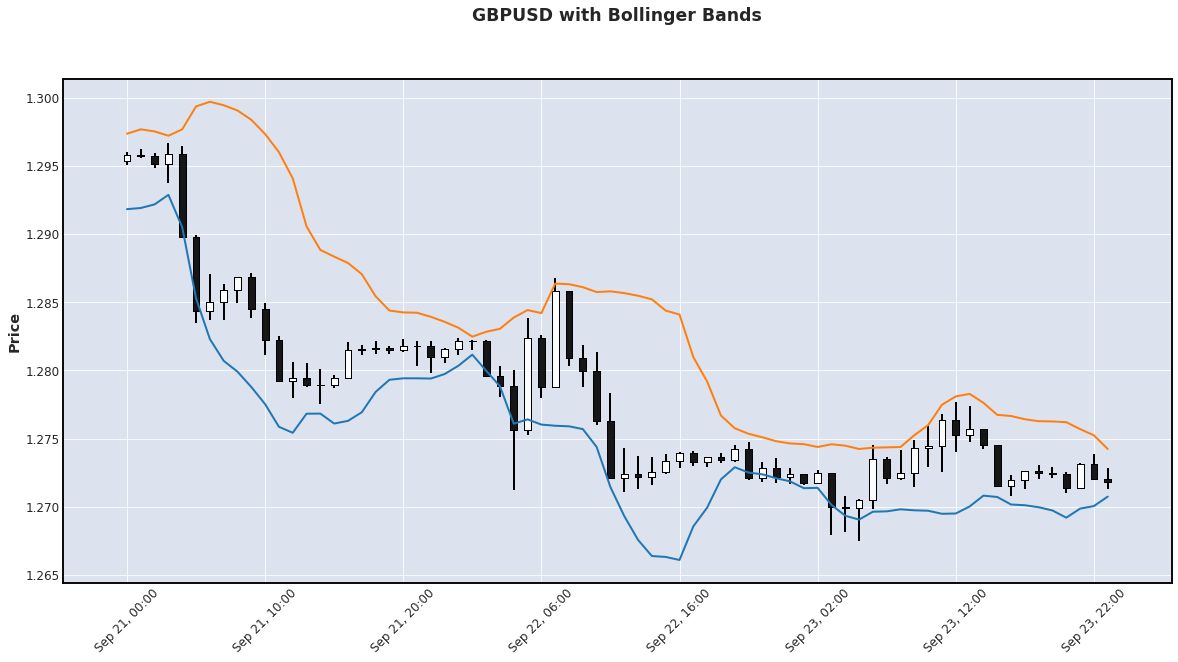

In [24]:
import mplfinance as mpf


tcdf = stored_df['09-21-2020':'09-23-2020'][['lowerband','upperband']]  # DataFrame with two columns
apd  = mpf.make_addplot(tcdf)
mpf.plot(mpf_df['09-21-2020':'09-23-2020'], type='candle', title='GBPUSD represented by candlesticks', figratio=(22,10))
mpf.plot(mpf_df['09-21-2020':'09-23-2020'], type='candle', title='GBPUSD with Bollinger Bands', figratio=(22,10), addplot=apd)

# mpf.plot(stored_df['09-25-2020':'10-01-2020'],type='candle',volume=False,
#          show_nontrading=False, figratio=(16,10), style='charles', addplot=apd)

# Displaying EMA, Stochastic and Bollinger indicator features

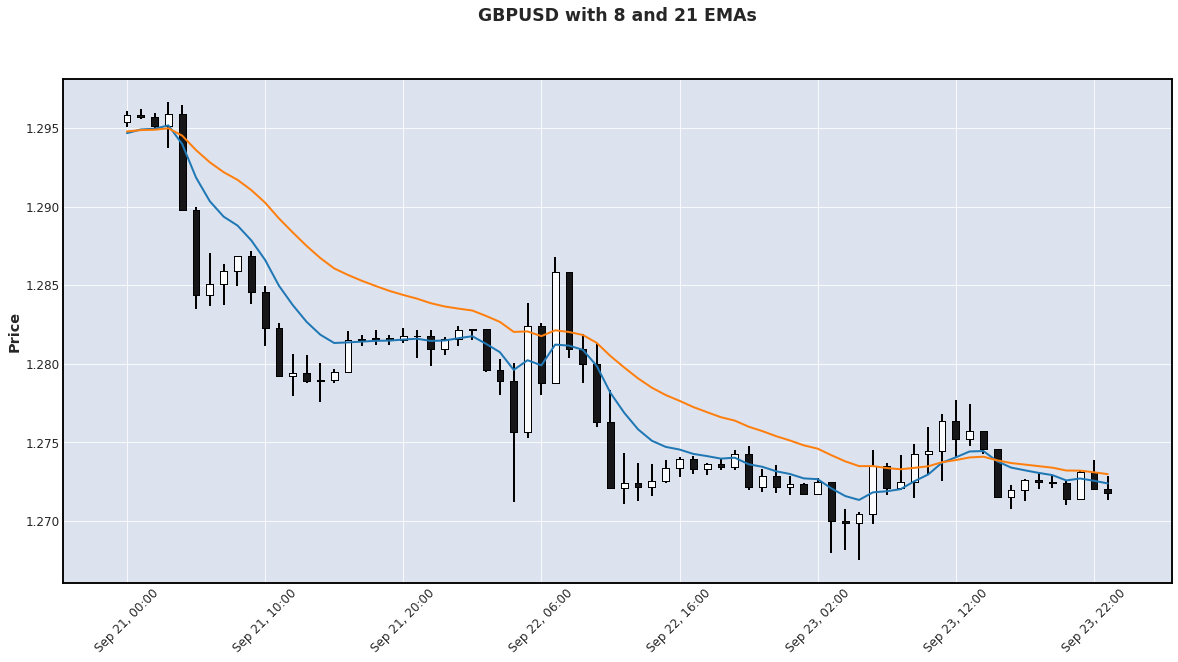

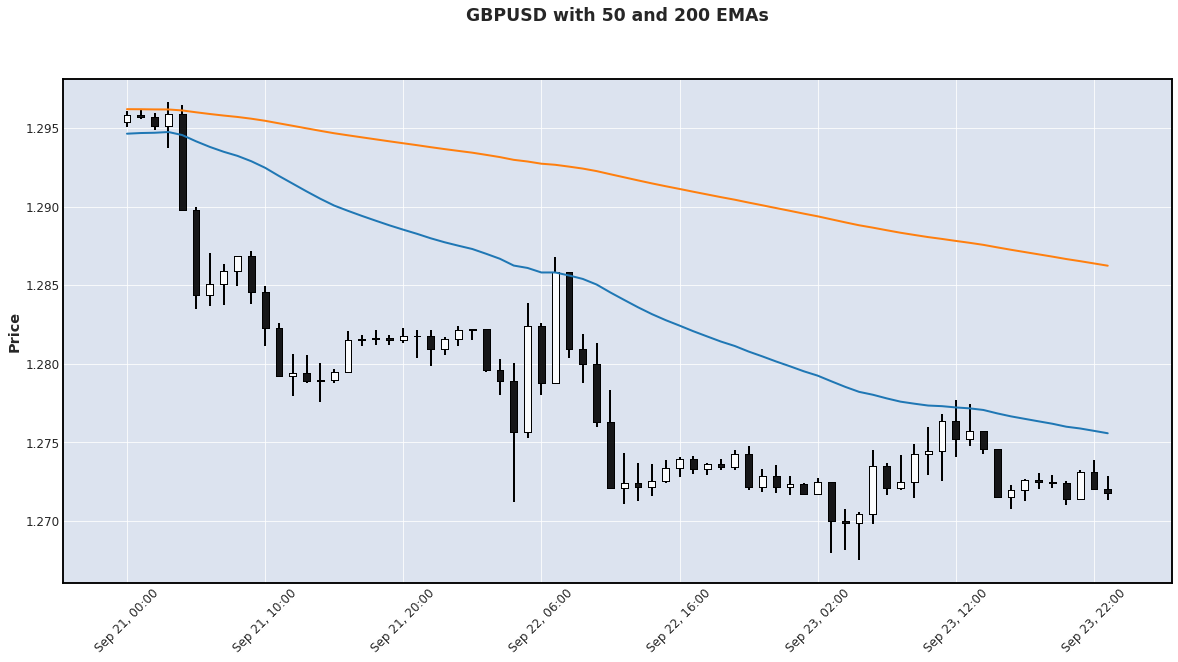

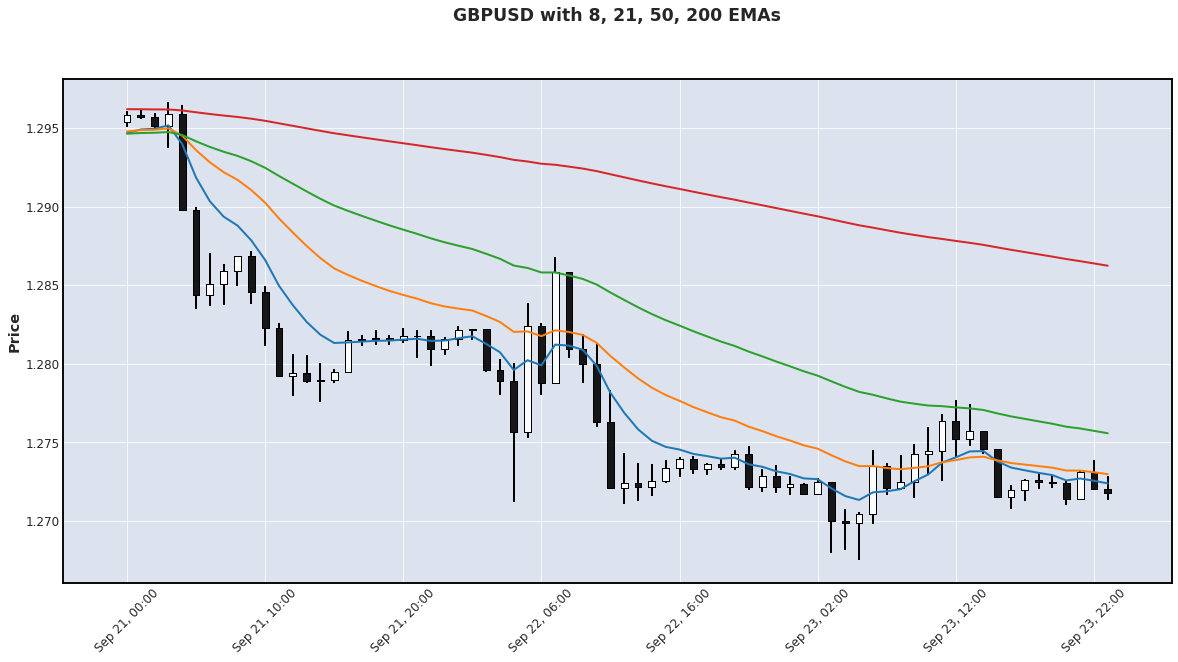

In [25]:
# tcdf = stored_df['09-25-2020':'10-01-2020'][['lowerband','upperband']]  # DataFrame with two columns
# apd  = mpf.make_addplot(tcdf)
# mpf.plot(mpf_df['09-25-2020':'10-01-2020'], type='candle', title='GBPUSD with Bollinger Bands', figratio=(22,10), addplot=apd)


ind_ema8_21  = mpf.make_addplot(stored_df['09-21-2020':'09-23-2020'][['ema8', 'ema21']])
ind_ema50_200  = mpf.make_addplot(stored_df['09-21-2020':'09-23-2020'][['ema50', 'ema200']])
ind_ema8_21_50_200  = mpf.make_addplot(stored_df['09-21-2020':'09-23-2020'][['ema8', 'ema21', 'ema50', 'ema200']])

mpf.plot(mpf_df['09-21-2020':'09-23-2020'],figratio=(22,10), type='candlestick', addplot=ind_ema8_21, title='GBPUSD with 8 and 21 EMAs')
mpf.plot(mpf_df['09-21-2020':'09-23-2020'],figratio=(22,10), type='candlestick', addplot=ind_ema50_200, title='GBPUSD with 50 and 200 EMAs')
mpf.plot(mpf_df['09-21-2020':'09-23-2020'],figratio=(22,10), type='candlestick', addplot=ind_ema8_21_50_200, title='GBPUSD with 8, 21, 50, 200 EMAs')

In [26]:
tcdf = stored_df['09-21-2020':'09-23-2020'][['lowerband','upperband']  # DataFrame with two columns
apd  = [ mpf.make_addplot(tcdf),  ]
mpf.plot(mpf_df['09-21-2020':'09-23-2020'],figratio=(22,10), type='candlestick', addplot=ind_ema8_21_50_200, title='GBPUSD with 8, 21, 50, 200 EMAs')
                                            
ind_emas_boll  = mpf.make_addplot(stored_df['09-21-2020':'09-23-2020'][['ema8', 'ema21', 'ema50', 'ema200', 'lowerband','upperband']])                            

SyntaxError: invalid syntax (<ipython-input-26-e0b81e6170d3>, line 2)

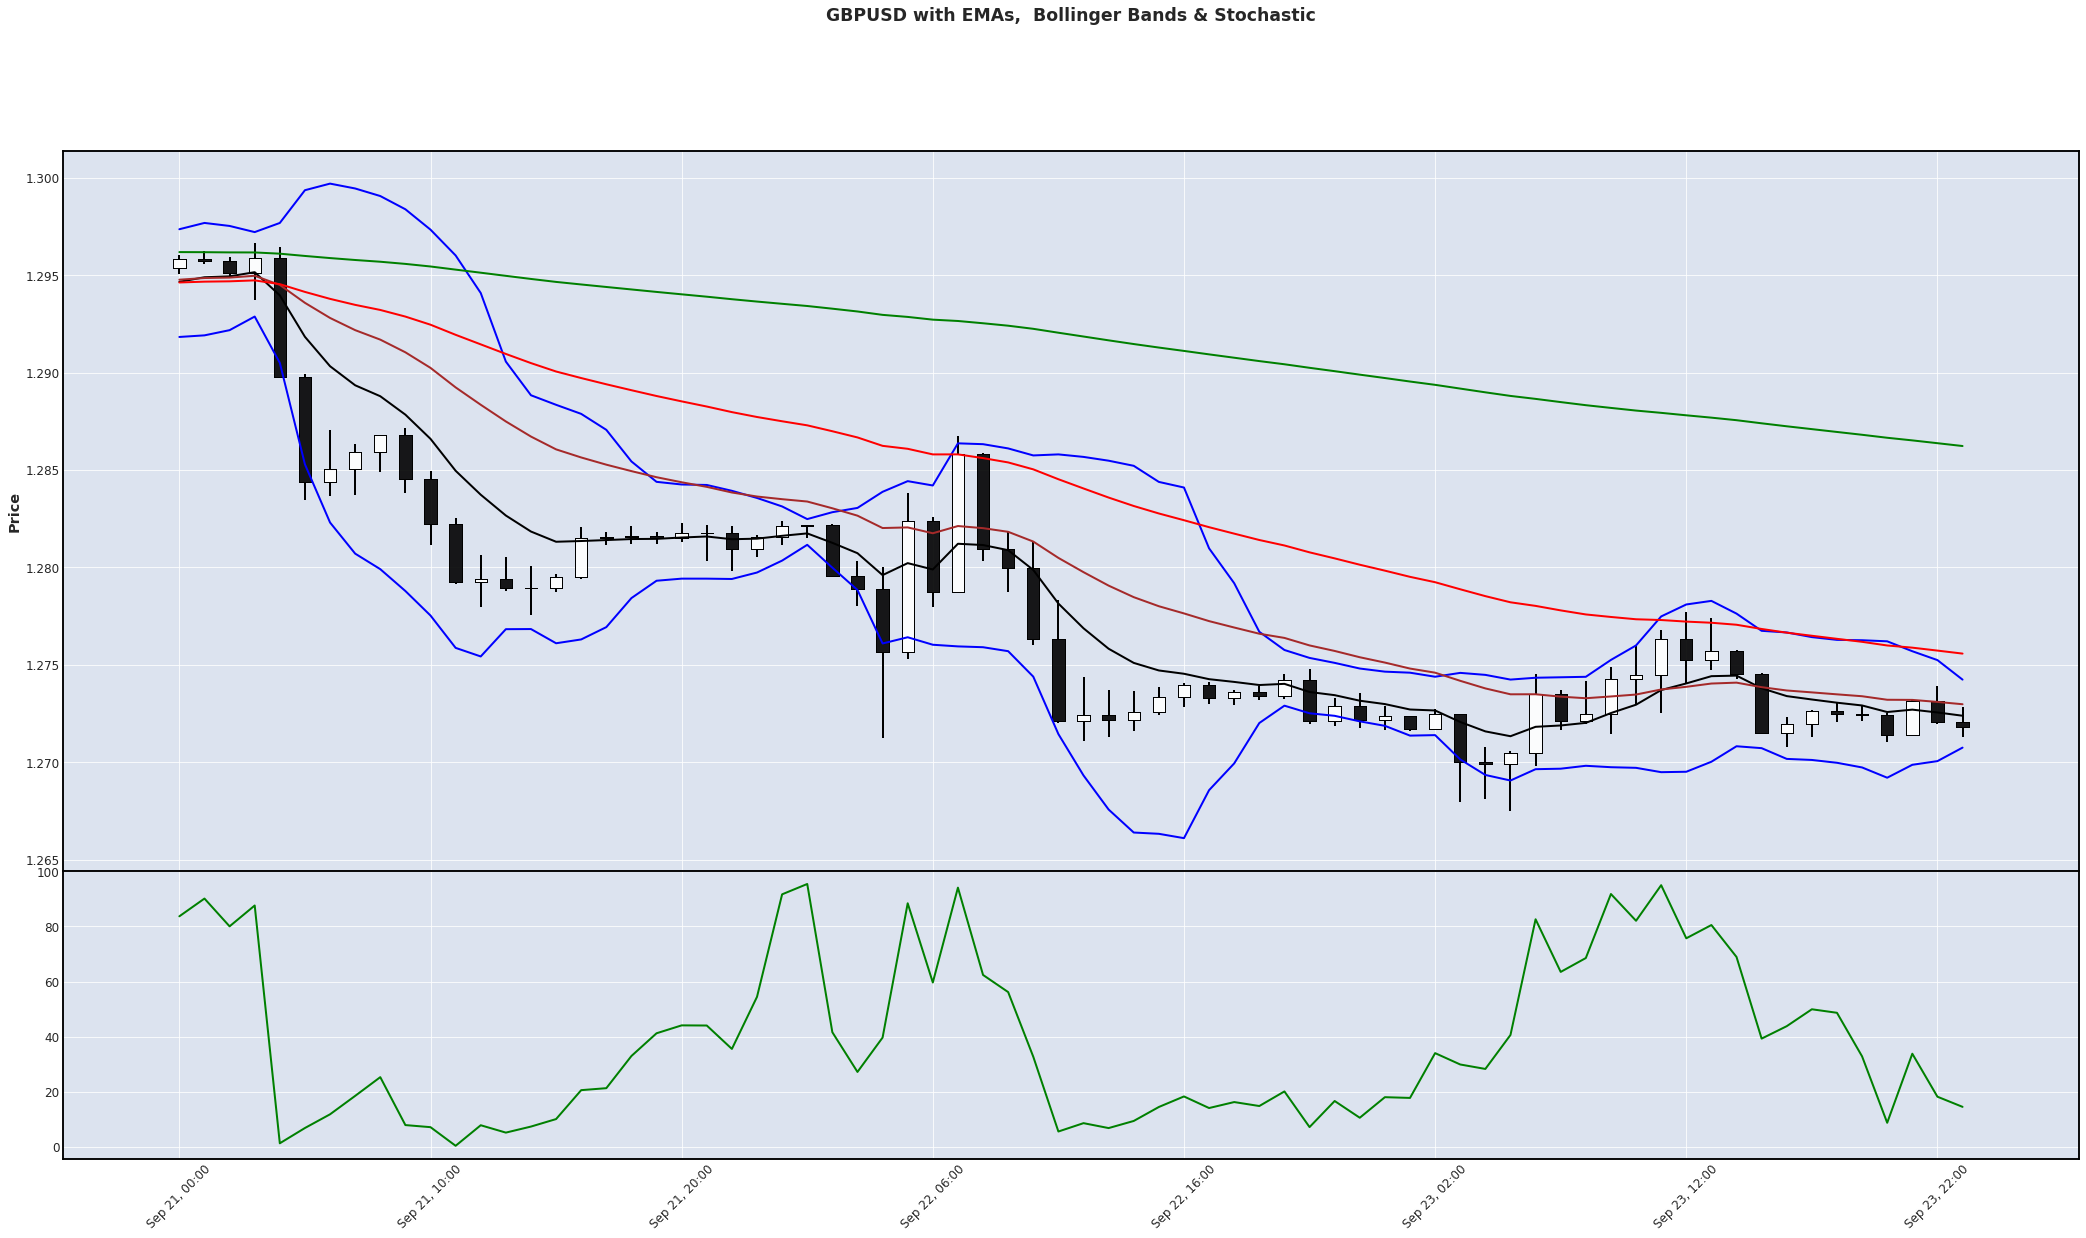

In [27]:
ind_emas_boll  = mpf.make_addplot(
    stored_df['09-21-2020':'09-23-2020'][['ema8', 'ema21', 'ema50', 'ema200', 'lowerband','upperband']])        

ap0 = [ mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['lowerband'],color='b'),  # uses panel 0 by default
        mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['upperband'],color='b'),  # uses panel 0 by default
        mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['ema8'],color='black'),  # uses panel 0 by default
        mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['ema21'],color='brown'),  # uses panel 0 by default
        mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['ema50'],color='red'),  # uses panel 0 by default
        mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['ema200'],color='green'),  # uses panel 0 by default
        mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['stochastic'], color='g', panel='lower') # lower panel
      ]
mpf.plot(mpf_df['09-21-2020':'09-23-2020'], figratio=(40,20), type='candle',volume=False,addplot=ap0, title='GBPUSD with EMAs,  Bollinger Bands & Stochastic')  

#ap2 = [ mpf.make_addplot(stored_df['09-21-2020':'09-23-2020']['stochastic'], color='g', panel='lower') ]  # panel 2 specified
      
#mpf.plot(mpf_df['09-21-2020':'09-23-2020'], figratio=(22,10), type='candle',volume=False,addplot=ap2)

The above indicators are commonly used for interpreting the trend & momentum of the price of a financial instrument. 
When looking at how price behaves around this EMAs you may be able to see repeating patterns. These recurring patterns can help predict price or direction of  price within a certain time frame.